## 1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
* For consistency, dataset should have **1000** samples and a `random_seed=42`.
* Turn the data into PyTorch tensors, splitting it into test/train using `train_test_split` with 80% as training and 20% as test.

In [80]:
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split

N_SAMPLES = 1000
RANDOM_STATE = 42
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

In [91]:
# Create dataset with X and y
X, y = datasets.make_moons(
	n_samples=N_SAMPLES,
	shuffle=True,
	noise=0.1,
	random_state=RANDOM_STATE
)

X[:5], y[:5]

(array([[-0.05146968,  0.44419863],
        [ 1.03201691, -0.41974116],
        [ 0.86789186, -0.25482711],
        [ 0.288851  , -0.44866862],
        [-0.83343911,  0.53505665]]),
 array([1, 1, 1, 1, 0]))

In [92]:
# Turn X and y into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [93]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
													y, 
													test_size=TEST_SIZE,
													random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting data you've create in 1. Feel free to use any combination of PyTorch layers.

In [94]:
from torch import nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [95]:
class ExerciseModel(nn.Module):
	def __init__(
			self,
			input_features: int = 2,
			output_features: int = 1,
			hidden_units: int = 16
			):
		super().__init__()

		# Architecture of the model: 3 Linear layers with non-linear activation functions between them
		self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_units)
		self.layer2 = nn.ReLU()
		self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
		self.layer4 = nn.ReLU()
		self.layer5 = nn.Linear(in_features=hidden_units, out_features=output_features)
		self.layer6 = nn.ReLU()

	def forward(self, x):
		return self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))

In [96]:
model = ExerciseModel().to(device)
model

ExerciseModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): ReLU()
  (layer5): Linear(in_features=16, out_features=1, bias=True)
  (layer6): ReLU()
)

## 3. Setup a binary classification compatibile loss function and optimizer to use when training the model.

In [97]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(
	params=model.parameters(),
	lr=0.01
	)

## 4. Setup a training and testing loop to fit the model created in 2. to the data from 1. 
* Measure the model accuracy - either use your own metric or use ones from `TorchMetrics`
* Train the model long enough to reach over 96% accuracy
* Training loop should output progress every 10 epochs (training and test loss, accuracy)

In [98]:
from torchmetrics.classification import BinaryAccuracy
from helper_functions import accuracy_fn

torchmetric_acc = BinaryAccuracy(threshold=0.5).to(device)

In [99]:
# Setup the randomness
torch.manual_seed(RANDOM_STATE)
torch.mps.manual_seed(RANDOM_STATE)

# Move tensors to 'device'
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Setup number of epochs - eyballed
EPOCHS = 300

for epoch in range(EPOCHS+1):
	### TRAINING
	model.train()

	# Forward pass
	y_logits = model(X_train).squeeze()
	y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> pred labels

	# Loss/acc
	loss = loss_fn(y_logits, y_train)
	#acc = torchmetric_acc(y_preds, y_train)
	acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

	# Zero grad
	optimizer.zero_grad()

	# Backward pass
	loss.backward()

	# Step
	optimizer.step()

	### TESTING
	model.eval()
	with torch.inference_mode():
		test_logits = model(X_test).squeeze()
		test_preds = torch.round(torch.sigmoid(test_logits))

		test_loss = loss_fn(test_logits, y_test)
		#test_acc = torchmetric_acc(test_preds, y_test)
		test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

	if epoch % 10 == 0:
			print(f"Epoch: {epoch} | Loss: {loss:.3f} | Acc: {acc:.2f}% | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.695 | Acc: 50.00% | Test loss: 0.673 | Test acc: 50.00%
Epoch: 10 | Loss: 0.519 | Acc: 80.62% | Test loss: 0.516 | Test acc: 76.50%
Epoch: 20 | Loss: 0.360 | Acc: 83.50% | Test loss: 0.366 | Test acc: 81.00%
Epoch: 30 | Loss: 0.285 | Acc: 86.38% | Test loss: 0.282 | Test acc: 85.50%
Epoch: 40 | Loss: 0.247 | Acc: 88.50% | Test loss: 0.241 | Test acc: 90.00%
Epoch: 50 | Loss: 0.229 | Acc: 89.75% | Test loss: 0.221 | Test acc: 90.50%
Epoch: 60 | Loss: 0.212 | Acc: 90.50% | Test loss: 0.204 | Test acc: 90.50%
Epoch: 70 | Loss: 0.191 | Acc: 91.50% | Test loss: 0.186 | Test acc: 91.50%
Epoch: 80 | Loss: 0.165 | Acc: 92.75% | Test loss: 0.159 | Test acc: 92.50%
Epoch: 90 | Loss: 0.132 | Acc: 94.25% | Test loss: 0.123 | Test acc: 95.50%
Epoch: 100 | Loss: 0.095 | Acc: 97.12% | Test loss: 0.087 | Test acc: 98.00%
Epoch: 110 | Loss: 0.064 | Acc: 98.62% | Test loss: 0.056 | Test acc: 99.00%
Epoch: 120 | Loss: 0.042 | Acc: 99.12% | Test loss: 0.036 | Test acc: 100.00%
Epoch: 13

## 5. Make predictions with trained model and plot them using `plot_decision_boundary()` from the notebook.

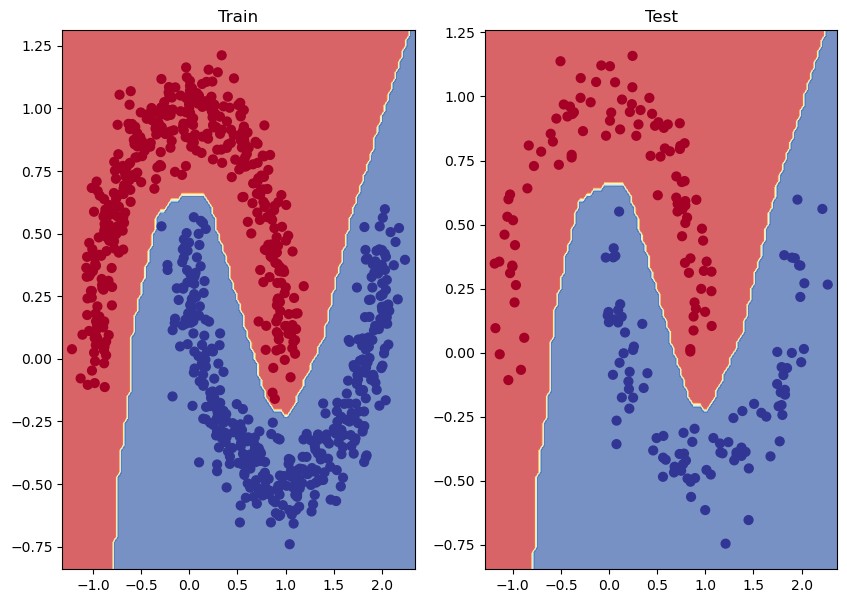

In [100]:
from helper_functions import plot_decision_boundary, plot_predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)